<a href="https://colab.research.google.com/github/joshdsolis/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module2-polynomial-regression/Polynomial_Log_linear_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from numpy import array
from numpy import argmax

In [102]:
##### Your Code Here #####
# Loading and cleaning data
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
pd.set_option('display.max_columns', 100)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [103]:
#Filling NaN values of columns that have a lot of data, but a few Nan's
df = df.fillna(df.mean())
df.head(20)
#df.MiscFeature.unique()
pd.get_dummies(df.Neighborhood)

df.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

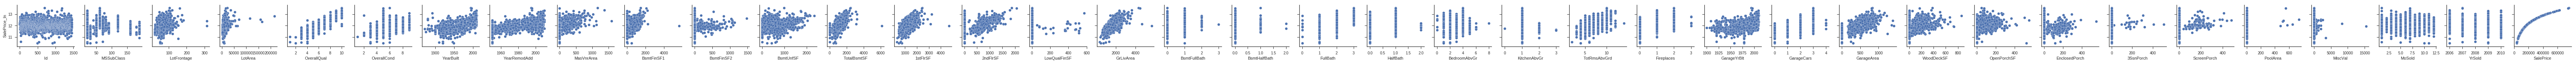

In [104]:
df= df.select_dtypes(['number'])
sns.set(style="ticks", color_codes=True)

# Getting log of sale price
df['SalePrice_ln'] = np.log(df['SalePrice'])

# Generate a list of column headers not including price
x_columns = df.columns.drop('SalePrice_ln')

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data=df, y_vars=['SalePrice_ln'], x_vars=x_columns)

In [0]:
# First polynomial feature
df['OverallQualSq'] = df['OverallQual']**2

In [0]:
# Second polynomial feature
df['BsmtFinSF1SqRt'] = np.sqrt(df['BsmtFinSF1'])

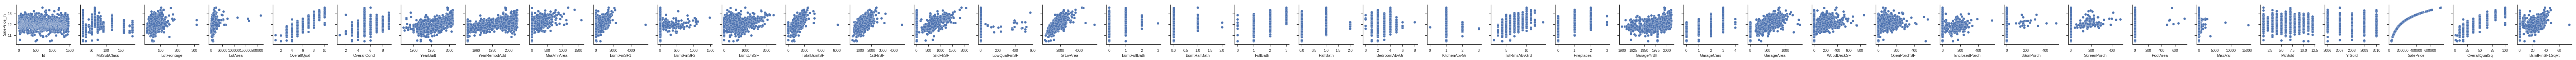

In [107]:
# Generate a list of column headers not including price
x_columns = df.columns.drop('SalePrice_ln')

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data=df, y_vars=['SalePrice_ln'], x_vars=x_columns)

In [0]:
# Interaction feature
df['QualxCond'] = df['OverallQual']*df['OverallCond']

# Engineering new features
df['totalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['LowQualFinSF']
df['totalRating1'] = df['OverallQual'] * df['totalSF']
df['totalRating2'] = df['QualxCond'] * df['totalSF']
df['totalRating3'] = df['OverallQualSq'] * df['totalSF']
df['hmBaths'] = df['totalSF']*df['FullBath']
df['extras'] = df['GarageCars']+df['Fireplaces']+df['FullBath'] + df['HalfBath']
df['experiment1'] = df['totalRating1'] * df['extras']
df['experiment2'] = df['totalRating2'] * df['extras']
df['experiment3'] = df['totalRating3'] * df['extras']
df['random'] = df['YearBuilt'] * df['OverallQual']

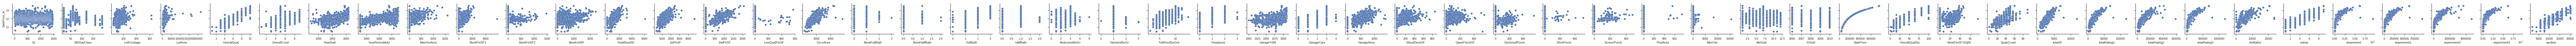

In [136]:
# Generate a list of column headers not including price
x_columns = df.columns.drop('SalePrice_ln')

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data=df, y_vars=['SalePrice_ln'], x_vars=x_columns)

In [137]:
y = df.loc[:, ['SalePrice_ln']].values
X = df.loc[:, ['OverallQual', 'OverallCond', 'YearBuilt',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'OverallQualSq', 'BsmtFinSF1SqRt', 
               'QualxCond', 'totalSF', 'totalRating1','totalRating2','totalRating3', 'hmBaths',
               'extras','experiment1','experiment2','experiment3']].values

# Slit into test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.5, random_state=42)

# fit model using train datasets
model = LinearRegression()
model.fit(X_train, Y_train)

# Create new predictions using x_test
y_pred = model.predict(X_test)

# Measure Accuracy using y_test and y_pred
RMSE = (np.sqrt(mean_squared_error(Y_test, y_pred)))
R2 = r2_score(Y_test, y_pred)

print('RMSE is {}'.format(RMSE))
print('R^2 is {}'.format(R2))

print("coefficients: ", model.coef_[0])
print("intercepts: ", model.intercept_)

RMSE is 0.14727637127909107
R^2 is 0.8699277976191764
coefficients:  [-3.52758281e-01  1.31915037e-01  3.24887637e-03 -5.23785021e-05
 -1.17014368e-04  1.01477371e-04  6.29052927e-07 -4.76604883e-05
  5.44459355e-05 -9.34748139e-02 -6.95529157e-03  1.56046518e-02
  1.04332401e-04  5.07033396e-02  4.29785965e-03 -1.46555366e-02
 -6.25684320e-05  1.48833503e-04  8.77534027e-07 -1.68473702e-05
  2.02976525e-05  7.50907819e-02 -8.25487030e-06  4.77049932e-08
  9.31761991e-07]
intercepts:  [4.74150681]
